## Quality Check Diagnostic Work

This notebook illustrates some quality control steps that should be considered when analyzing a new dataset. In this example we'll use the `WindToolKitQualityControlDiagnosticSuite` class to automate some of the QC analysis for SCADA data.

The `WindToolKitQualityDiagnosticSuite` is a subclass of the `QualityControlDiagnosticSuite` that adds additional methods for the use of the NREL WindToolKit database in addition to all the base QC methods.

### Step 1: Load in Data

To load in the data, we can either preload the data, or pass in a full file path and have the QC class import the data file.

For this example we'll load in the data first, and remove the timezone data from the datetime stamp to demonstrate the process of uncovering the DST overlap in the data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from operational_analysis.methods.quality_check_automation import WindToolKitQualityControlDiagnosticSuite as QC

In [3]:
scada_df = pd.read_csv('./data/la_haute_borne/la-haute-borne-data-2014-2015.csv')

date = [s[0:10] for s in scada_df['Date_time']]
time = [s[11:19] for s in scada_df['Date_time']]
datetime = [date[s] + ' ' + time[s] for s in np.arange(len(date))]
scada_df['datetime'] = pd.to_datetime(datetime, format = "%Y-%m-%d %H:%M:%S")

scada_df.set_index('datetime', inplace = True, drop = False)

In [4]:
scada_df.head()

,Wind_turbine_name,Date_time,Ba_avg,P_avg,Ws_avg,Va_avg,Ot_avg,Ya_avg,Wa_avg,datetime
datetime,,,,,,,,,,
2014-01-01 01:00:00,R80736,2014-01-01T01:00:00+01:00,-1.00,642.78003,7.12,0.66,4.69,181.34000,182.00999,2014-01-01 01:00:00
2014-01-01 01:00:00,R80721,2014-01-01T01:00:00+01:00,-1.01,441.06000,6.39,-2.48,4.94,179.82001,177.36000,2014-01-01 01:00:00
2014-01-01 01:00:00,R80790,2014-01-01T01:00:00+01:00,-0.96,658.53003,7.11,1.07,4.55,172.39000,173.50999,2014-01-01 01:00:00
2014-01-01 01:00:00,R80711,2014-01-01T01:00:00+01:00,-0.93,514.23999,6.87,6.95,4.30,172.77000,179.72000,2014-01-01 01:00:00
2014-01-01 01:10:00,R80790,2014-01-01T01:10:00+01:00,-0.96,640.23999,7.01,-1.90,4.68,172.39000,170.46001,2014-01-01 01:10:00


In [5]:
scada_df.dtypes

Wind_turbine_name            object
Date_time                    object
Ba_avg                      float64
P_avg                       float64
Ws_avg                      float64
Va_avg                      float64
Ot_avg                      float64
Ya_avg                      float64
Wa_avg                      float64
datetime             datetime64[ns]
dtype: object

### Step 2: Initializing QC and Performing the Run Method

Now that we have our dataset with the necessary columns and datatypes, we are ready to perform our quality check diagnostic. This analysis will not make the adjustments for us, but it will allow us to quickly flag some key irregularities that we need to manage before going on. 

To start, let's initialize a QC object, qc, and call its run method. 

In [6]:
qc = QC(
    data=scada_df, 
    ws_field='Ws_avg', 
    power_field= 'P_avg', 
    time_field='datetime', 
    id_field='Wind_turbine_name', 
    freq='10T', 
    lat_lon=(48.45, 5.586),
    local_tz="Europe/Paris",
    timezone_aware=False,
    check_tz=False
)

INFO:operational_analysis.methods.quality_check_automation:Initializing QC_Automation Object


Below is what the updated DataFrame object looks like after being read in and manipulated for the initial setup. Notice that there is now a UTC offset column, which directly translates to the `is_dst` column's `True`/`False` input for whether or not a particular timestamp is in Daylight Saving's Time (if it's used at all for the time zone).

In the below, the datetime column (not the index) should always remain in UTC time. Conveniently, Pandas provides two methods `tz_convert()` and `tz_localize()` to toggle back and forth between timezones, which will operate on the index of the DataFrame. 

In [7]:
qc._df.head()

,Wind_turbine_name,Date_time,Ba_avg,P_avg,Ws_avg,Va_avg,Ot_avg,Ya_avg,Wa_avg,datetime,datetime_localized,datetime_utc,utc_offset,is_dst
datetime_localized,,,,,,,,,,,,,,
2014-01-01 00:00:00+00:00,R80736,2014-01-01T01:00:00+01:00,-1.00,642.78003,7.12,0.66,4.69,181.34000,182.00999,2014-01-01 01:00:00,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:00:00+00:00,R80721,2014-01-01T01:00:00+01:00,-1.01,441.06000,6.39,-2.48,4.94,179.82001,177.36000,2014-01-01 01:00:00,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:00:00+00:00,R80790,2014-01-01T01:00:00+01:00,-0.96,658.53003,7.11,1.07,4.55,172.39000,173.50999,2014-01-01 01:00:00,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:00:00+00:00,R80711,2014-01-01T01:00:00+01:00,-0.93,514.23999,6.87,6.95,4.30,172.77000,179.72000,2014-01-01 01:00:00,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:10:00+00:00,R80790,2014-01-01T01:10:00+01:00,-0.96,640.23999,7.01,-1.90,4.68,172.39000,170.46001,2014-01-01 01:10:00,2014-01-01 01:10:00+01:00,2014-01-01 00:10:00+00:00,0 days 01:00:00,False


In [8]:
qc._df.dtypes

Wind_turbine_name                           object
Date_time                                   object
Ba_avg                                     float64
P_avg                                      float64
Ws_avg                                     float64
Va_avg                                     float64
Ot_avg                                     float64
Ya_avg                                     float64
Wa_avg                                     float64
datetime                            datetime64[ns]
datetime_localized    datetime64[ns, Europe/Paris]
datetime_utc                   datetime64[ns, UTC]
utc_offset                         timedelta64[ns]
is_dst                                        bool
dtype: object

In [9]:
qc.run()

INFO:operational_analysis.methods.quality_check_automation:Identifying Time Duplications
INFO:operational_analysis.methods.quality_check_automation:Identifying Time Gaps
INFO:operational_analysis.methods.quality_check_automation:Isolating Extrema Values
INFO:operational_analysis.methods.quality_check_automation:QC Diagnostic Complete


### Step 3: Deep Dive with QC Diagnostic Results

Let's take a deeper look at the results of our QC diagnostic. 

#### Perform a general scan of the distributions for each numeric variable

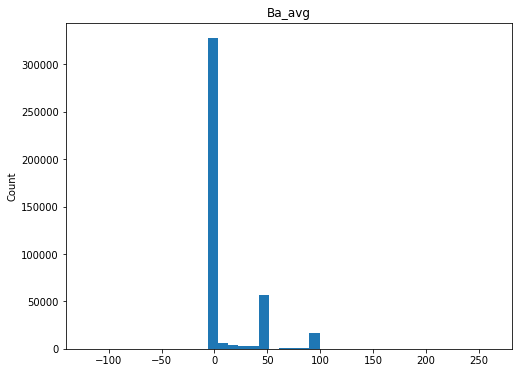

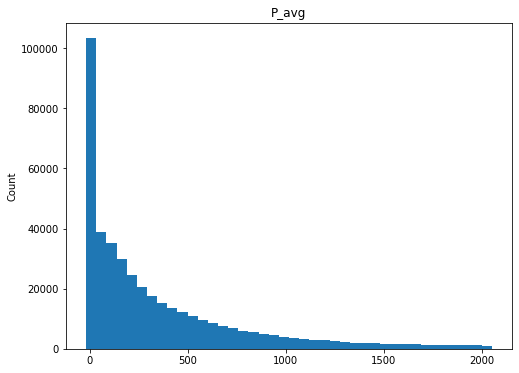

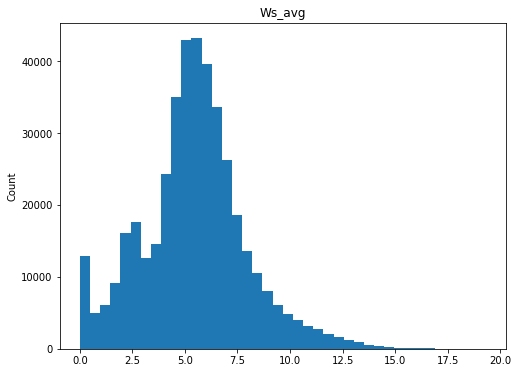

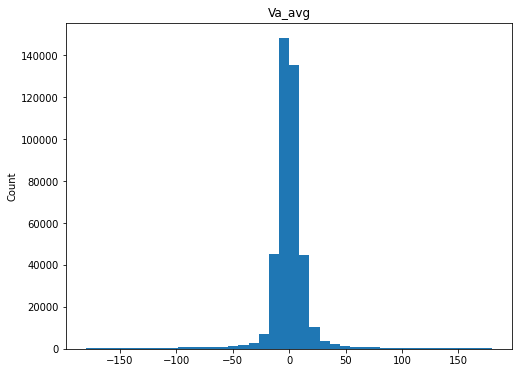

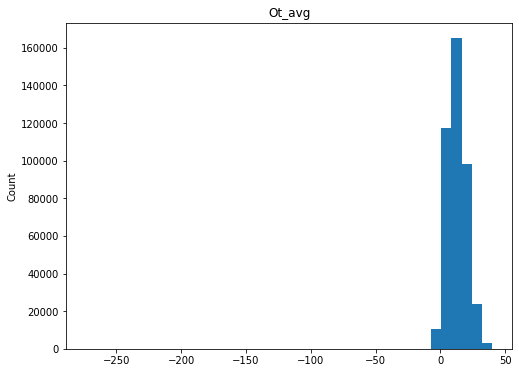

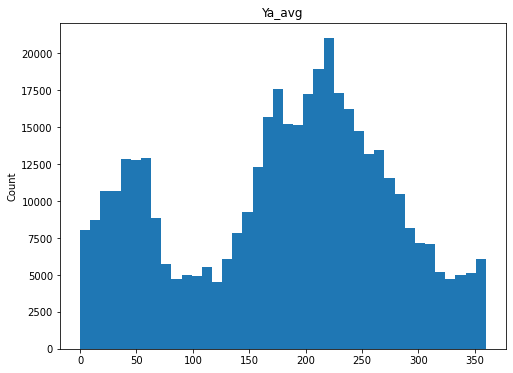

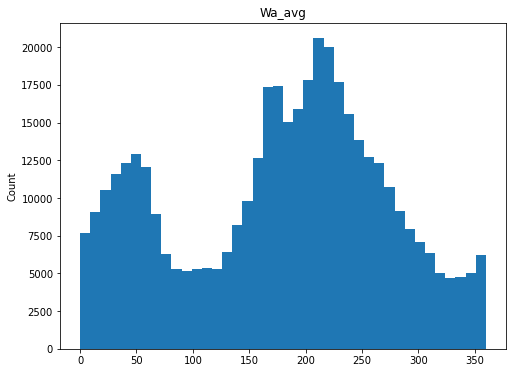

In [10]:
qc.column_histograms()

#### Check ranges of each variable

In [11]:
qc._max_min

,max,min
Wind_turbine_name,R80790,R80711
Date_time,2016-01-01T00:50:00+01:00,2014-01-01T01:00:00+01:00
Ba_avg,262.61,-121.26
P_avg,2051.87,-17.92
Ws_avg,19.31,0
Va_avg,179.99,-179.95
Ot_avg,39.89,-273.2
Ya_avg,360,0
Wa_avg,360,0
datetime,2016-01-01 00:50:00,2014-01-01 01:00:00


These values look fairly reasonable and consistent. 

#### Identify any timestamp duplications and timestamp gaps. 

Duplications in October and gaps in March would suggest DST.

In [12]:
qc._time_duplications 

datetime_localized
2014-03-30 01:00:00+00:00   2014-03-30 03:00:00
2014-03-30 01:00:00+00:00   2014-03-30 03:00:00
2014-03-30 01:00:00+00:00   2014-03-30 03:00:00
2014-03-30 01:00:00+00:00   2014-03-30 03:00:00
2014-03-30 01:10:00+00:00   2014-03-30 03:10:00
2014-03-30 01:10:00+00:00   2014-03-30 03:10:00
2014-03-30 01:10:00+00:00   2014-03-30 03:10:00
2014-03-30 01:10:00+00:00   2014-03-30 03:10:00
2014-03-30 01:20:00+00:00   2014-03-30 03:20:00
2014-03-30 01:20:00+00:00   2014-03-30 03:20:00
2014-03-30 01:20:00+00:00   2014-03-30 03:20:00
2014-03-30 01:20:00+00:00   2014-03-30 03:20:00
2014-03-30 01:30:00+00:00   2014-03-30 03:30:00
2014-03-30 01:30:00+00:00   2014-03-30 03:30:00
2014-03-30 01:30:00+00:00   2014-03-30 03:30:00
2014-03-30 01:30:00+00:00   2014-03-30 03:30:00
2014-03-30 01:40:00+00:00   2014-03-30 03:40:00
2014-03-30 01:40:00+00:00   2014-03-30 03:40:00
2014-03-30 01:40:00+00:00   2014-03-30 03:40:00
2014-03-30 01:40:00+00:00   2014-03-30 03:40:00
2014-03-30 01:50:00+0

In [13]:
qc._time_gaps

12678   2014-03-30 02:00:00
12679   2014-03-30 02:10:00
12680   2014-03-30 02:20:00
12681   2014-03-30 02:30:00
12682   2014-03-30 02:40:00
12683   2014-03-30 02:50:00
65094   2015-03-29 02:00:00
65095   2015-03-29 02:10:00
65096   2015-03-29 02:20:00
65097   2015-03-29 02:30:00
65098   2015-03-29 02:40:00
65099   2015-03-29 02:50:00
dtype: datetime64[ns]

Based on the duplicated timestamps, it does seem like there is a DST correction in spring but no time gap in the fall

#### Check the DST plot to look in more detail

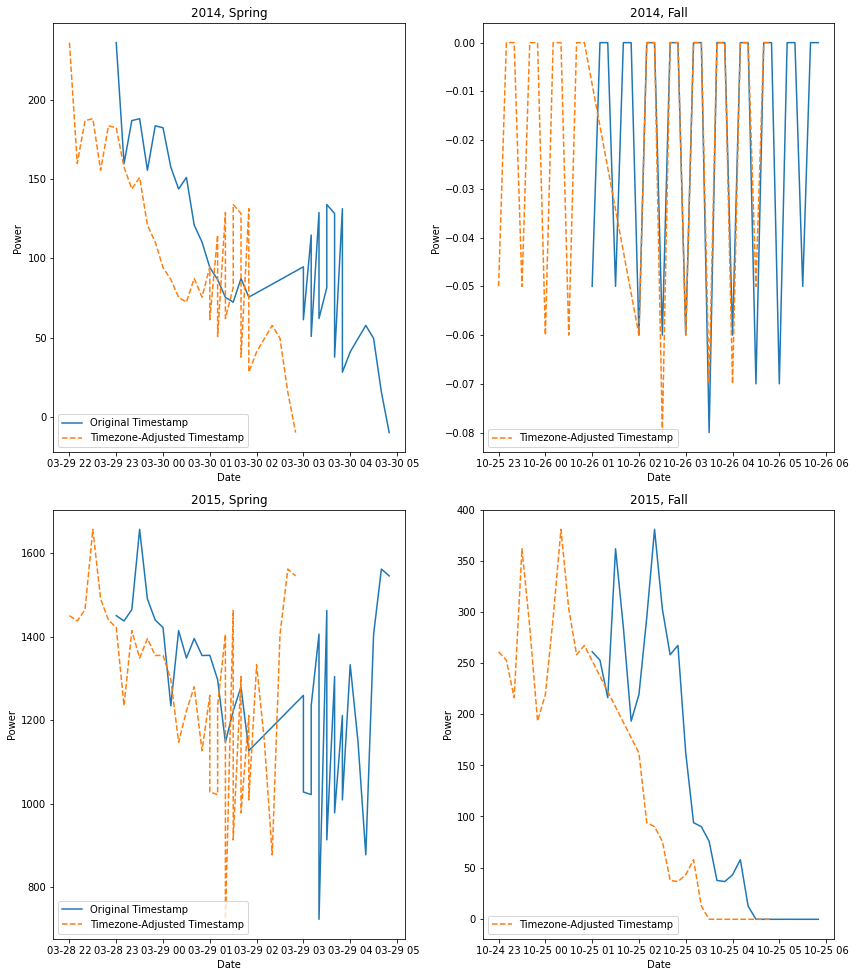

In [14]:
qc.daylight_savings_plot()

So we do in fact have a gap in the spring data when DST kicks in (as well as duplicated data for some reason) but not duplicated data in the fall.

The final question regarding datetime is whether we're in UTC or local. Given the daylights savings gap, it's likely we're in local. This is further confirmed by the raw datetime info provided in the SCADA file, which shows either a +1h or +2h timezone from UTC. So we are operating in local time. Therefore, the project import script for La Haute Borne should shift the timestep back to put it into UTC.

### Inspect the turbine power curves

Now that we have gathered some useful information about our timeseries, the one last check we may want to make is to inspect each turbine profile. We can look at each turbine's power curve and perform an initial scan for irregularities.

/Users/rhammond/Documents/GitHub/OpenOA/operational_analysis/methods/quality_check_automation.py:397: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, 4, n)


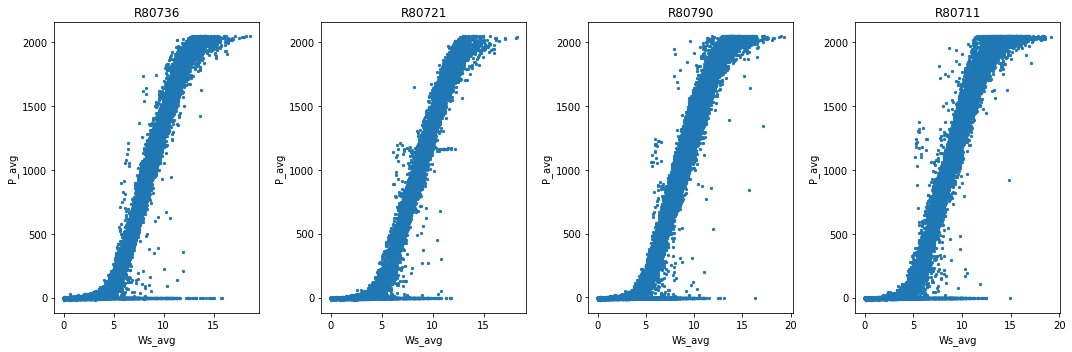

In [15]:
qc.plot_by_id('Ws_avg', 'P_avg')

Overall, these power curves look pretty common with some downtime, derating, and what look like a few erroneous data points. 

### Step 4: Performing adjustments on our data

Recall that this notebook is only for diagnostic QC of plant data and does not actually change the data in the project import script. Any issues identifed here should be incorporated into the project import script. 

Note that the necessary corrections have alreayd been applied to the project import script for this data.